In [1]:
# Data handling and processing
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Sklearn imports
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import accuracy_score

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File mgmt
import os

# misc
import time

os.chdir('Data')
!ls

Transactions_Village114
output.xlsx
output2.xlsx


In [2]:
path = 'Transactions_Village114/ds3170_tx_All_Data_5208_2019_1211_082948.txt'
df = pd.read_csv(path, sep="\t")
cols = ['Anon Student Id', 'Session Id', 'Duration (sec)', 'Level (Tutor Name)', 'Level (Tutor)', 'Problem Name', 'Problem View','Step Name', 'Attempt At Step','Is Last Attempt','Outcome', 'Input','CF (File)','CF (Matrix)','CF (Matrix Level)', 'CF (Matrix Order)', 'CF (Total Activity Problems)']
df = df[cols]
bubble_pop_df = df[df['Level (Tutor Name)'] == 'bubble_pop']
bpop_math_df = bubble_pop_df[bubble_pop_df['CF (Matrix)'] == 'math'] #6172

# X and y -> inputs and outputs for the classification model
cols = ['Duration (sec)', 'Level (Tutor)', 'Attempt At Step', 'CF (Matrix Level)', 'CF (Matrix Order)', 'Outcome']
X = bpop_math_df[cols]
y = X[['Outcome']]
X = X.drop(['Outcome'], axis=1)

C:\Users\jithe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3,7,37,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Helpful functions

In [10]:
# Clean duration (sec) columns: Convert all values to float, if not able to convert set value in that row as duration_mean
def clean_duration_col_with_mean(X):
    strings = 0
    ints = 0
    floats = 0
    other = 0
    cnt = 0
    sums = 0
    posn = []
    X_duration_arr = X['Duration (sec)'].array

    for i in range(len(X_duration_arr)):
        if isinstance(X_duration_arr[i], int):
            ints += 1
        elif isinstance(X_duration_arr[i], str):
            strings += 1
            try:
                X_duration_arr[i] = float(X_duration_arr[i])
            except ValueError:
#                 print("Cant convert to a float", X_duration_arr[i], "Position: ",i)
                posn.append(i)
        elif isinstance(X_duration_arr[i], float):
            floats += 1
    
        if isinstance(X_duration_arr[i], float):
            sums += X_duration_arr[i]
            cnt += 1

    duration_mean = sums/cnt
    for i in range(len(posn)):
        X_duration_arr[posn[i]] = duration_mean

    for i in range(len(X_duration_arr)):
        col = bpop_math_df.columns.get_loc('Duration (sec)')
        val = X_duration_arr[i]
        X.iloc[i, col] = val
    
    return X

# Ordinal encodes a column
def ordinal_encode_col(X, colname):
    enc = OrdinalEncoder()
    level_tutor = X[colname].tolist()
    tutor_level_2dlist = []
    for i in range(len(level_tutor)):
        tutor_level_2dlist.append([level_tutor[i]])

    enc.fit(tutor_level_2dlist)

    col = X.columns.get_loc(colname)
    num_entries = X.count()[colname]
    for i in range(num_entries):
        val = X.iloc[i, col]
        val = enc.transform([[val]])[0][0]
        X.iloc[i, col] = val
    
    return X

def rfe(X_train, y_train, apply_rfe):
    if apply_rfe == False:
        return
    data_final_vars=X_train.columns.values.tolist()
    y_=['y']
    X=[i for i in data_final_vars if i not in y_]
    logreg = LogisticRegression()
    rfe = RFE(logreg, 20)
    rfe = rfe.fit(X_train, y_train)
#     print("RFE Support: ",rfe.support_)
#     print("RFE Ranking: ", rfe.ranking_)

# incorrect -> 0, correct -> 1
# set_zero = "INCORRECT" means incorrect will be set to 0 and other value as 1
def encode_outputs(y, colname, set_zero):
    col = y.columns.get_loc(colname)
    for i in range(y.count()[colname]): 
        val = y.iloc[i, col]
        if val == set_zero:
            val = 0
        else: 
            val = 1
        y.iloc[i, col] = val
    
    return y

def encode_categorical_cols(X, encoder, col):

#   Ordinally encode categorical columns
    if encoder == "ordinal":
        for i in range(len(col)):
            X = ordinal_encode_col(X, col[i])
    
    return X

def normalize_data(X, norm):
    if norm == 'l1':
        X = sklearn.preprocessing.normalize(X, norm='l1', axis=1, copy=True, return_norm=False)
        X = pd.DataFrame(data=X, columns=cols[:len(cols)-1])
    
    elif norm == 'l2':
        X = sklearn.preprocessing.normalize(X, norm='l2', axis=1, copy=True, return_norm=False)
        X = pd.DataFrame(data=X, columns=cols[:len(cols)-1])
    
    return X


def run_logistic_regression(X, y, test_split, apply_rfe):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
    rfe(X_train, y_train, apply_rfe)
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    performance = 100 * logreg.score(X_test, y_test)
#     print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(performance))
    return performance
    
def run_k_neighbors_classifier(X, y, test_split, apply_rfe, neighbors):
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
    rfe(X_train, y_train, apply_rfe)       
    neigh = KNeighborsClassifier(n_neighbors=neighbors)
    neigh.fit(X_train, y_train)
    performance = 100 * neigh.score(X_test, y_test)
#     print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(performance))
    return performance

def run_svm(X, y, test_split, apply_rfe, svc_kernel):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)
    rfe(X_train, y_train, apply_rfe)   
    svm_model = svm.SVC(kernel=svc_kernel)
    print("CREATE MODEL")
    svm_model.fit(X_train, y_train)
    print("FIT")
    #Predict the response for test dataset
    y_pred = svm_model.predict(X_test)
    perf = 100 * metrics.accuracy_score(y_test, y_pred)
    print("Accuracy:",perf)
    return perf

def run_nn(X, y, test_split, lr, epochs, layer_sizes, n):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Make everything as float type

    X_train['Duration (sec)'] = X_train['Duration (sec)'].astype(float)
    X_train['Level (Tutor)'] = X_train['Level (Tutor)'].astype(float)
    X_train['CF (Matrix Level)'] = X_train['CF (Matrix Level)'].astype(float)
    X_train['CF (Matrix Order)'] = X_train['CF (Matrix Order)'].astype(float)

    X_test['Duration (sec)'] = X_test['Duration (sec)'].astype(float)
    X_test['Level (Tutor)'] = X_test['Level (Tutor)'].astype(float)
    X_test['CF (Matrix Level)'] = X_test['CF (Matrix Level)'].astype(float)
    X_test['CF (Matrix Order)'] = X_test['CF (Matrix Order)'].astype(float)

    # Convert to torch tensors

    X_train_tensor = torch.tensor(X_train.values).float()
    X_test_tensor = torch.tensor(X_test.values).float()
    y_train_tensor = torch.tensor(y_train).float()
    y_test_tensor = torch.tensor(y_test).float()
    
    
    # Model class
    class StudentNet(nn.Module):
    
        def __init__(self, input_size, layer_sizes, num_classes, n):
            super(StudentNet, self).__init__()
            
            if len(layer_sizes) == 0:
                layer_sizes = [30]
            self.layer_sizes = layer_sizes
            
            self.fc1 = nn.Linear(input_size, n)
            self.fc2 = nn.Linear(n, n)
#             self.fc2a = nn.Linear(n, n)
            self.fc3 = nn.Linear(n, n)
            self.dropout = nn.Dropout()
            self.fc4 = nn.Linear(n, num_classes)
            
#             self.fc = []
#             self.fc.append(nn.Linear(input_size, layer_sizes[0]))
#             for i in range(len(layer_sizes) - 1):
#                 self.fc.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
#             self.fc.append(nn.Linear(layer_sizes[len(layer_sizes) - 1], num_classes))
    
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
#             x = F.relu(self.fc3(x))
            x = self.fc4(x)
#             for i in range(len(self.layer_sizes) - 1):
#                 x = F.relu(self.fc[i])
#             x = self.fc[len(self.layer_sizes) - 1](x)
            return x
    
        def predict(self,x):
            pred = F.softmax(self.forward(x))
            ans = []
            #Pick the class with maximum proba
            for t in pred:
                if t[0]>t[1]:
                    ans.append(0)
                else:
                    ans.append(1)
            return torch.tensor(ans)
    
    model = StudentNet(5, layer_sizes, 2, n)
    print(model)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    test_losses = []
    train_losses = []
    
    for i in range(epochs):
        #Predict the output for Given input
        y_pred = model.forward(X_train_tensor)
        loss = loss_function(y_pred, y_train_tensor.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%(epochs/50) == 0:
            y_test_pred = model.forward(X_test_tensor)
            test_loss = loss_function(y_test_pred, y_test_tensor.long())
            test_losses.append(test_loss)
            train_losses.append(loss)
        
        if i%(epochs/5) == 0:
            print("Loss: ", loss.item())
        
    x_axis = [0.02*epochs*(i+1) for i in range(len(test_losses))]
    perf = 100 * accuracy_score(model.predict(X_test_tensor),y_test_tensor)
    print("ACCURACY: ", perf, "%")
    plt.plot(x_axis, train_losses, color="black", label="train loss")
    plt.plot(x_axis, test_losses, color="red", label="test loss")
    plt.title("Loss vs epochs")
    plt.legend()
    plt.ylim(0.57, 0.63)
    plt.show()
    return perf
    

def run_algo(algo, X, y, clean_method, encoder, norm, test_split, apply_rfe, categorical_cols, neighbors, svc_kernel, lr, epochs, layer_sizes, n):
    
    if clean_method == "mean":
        X = clean_duration_col_with_mean(X)
    
    X = encode_categorical_cols(X, encoder, categorical_cols)
    X = normalize_data(X, norm)
    y = encode_outputs(y, 'Outcome', 'INCORRECT').values.ravel()
    perf = 0
    if algo == "logistic_regression":
        perf = run_logistic_regression(X, y, test_split, apply_rfe)
    
    elif algo == "k_neighbors_classifier":
        perf = run_k_neighbors_classifier(X, y, test_split, apply_rfe, neighbors)
    
    elif algo == "svm":
        perf = run_svm(X, y, test_split, apply_rfe, svc_kernel)
        
    elif algo == "nn":
        perf = run_nn(X, y, test_split, lr, epochs, layer_sizes, n)
      
    return perf
    

C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

StudentNet(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)
Loss:  1.4029390811920166
Loss:  0.5961574912071228
Loss:  0.5971258282661438
Loss:  0.5968116521835327
Loss:  0.5982248783111572


C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:199: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ACCURACY:  68.98785425101215 %


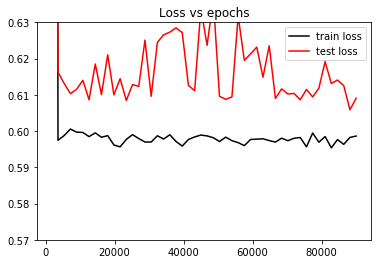

C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

StudentNet(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)
Loss:  0.8828209042549133
Loss:  0.5973377227783203
Loss:  0.5972996354103088
Loss:  0.5962162613868713
Loss:  0.5956688523292542


C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:199: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ACCURACY:  69.31174089068826 %


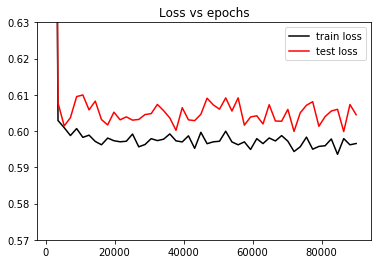

C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\jithe\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

StudentNet(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)
Loss:  1.1032568216323853
Loss:  0.6020057797431946


KeyboardInterrupt: 

In [14]:
# mean median or mode (#FIXME: only supports mean for now)
clean_method = "mean" 

# ordinal, onehot etc.. (#FIXME: only supports ordinal encoding for now)
encoder = "ordinal" 

# cols that are categories rather than numbers and have to be encoded
categorical_cols = ['Level (Tutor)']

# none, l1, l2 etc..
norm = "none" 

# set True to apply Recursive Feature Elimination
apply_rfe = True

test_split = 0.15
num_runs = 10

# k neighbors classifier
neighbors = 5

# linear, poly, rbf, sigmoid
svc_kernel = 'linear'

# Params for For Neural networks
lr = 0.0003
epochs = 90000
layer_sizes = [30, 30, 30]
# network width
n = 5

# Supports logistic_regression, k_neighbors_classifier, svm, nn
algo = "nn"

# used to store performance of each run in num_runs
total_perfs = []

for i in range(num_runs):
    X = bpop_math_df[cols]
    X = X.sample(frac=1).reset_index(drop=True)
    y = X[['Outcome']]
    X = X.drop(['Outcome'], axis=1)
    perf = run_algo(algo, X, y, clean_method, encoder, norm, test_split, apply_rfe, categorical_cols, neighbors, svc_kernel, lr, epochs, layer_sizes, n)
    total_perfs.append(perf)

print(total_perfs)
print("ACCURACY at n=5:", 100*sum(total_perfs)/num_runs)
n=6

for i in range(num_runs):
    X = bpop_math_df[cols]
    X = X.sample(frac=1).reset_index(drop=True)
    y = X[['Outcome']]
    X = X.drop(['Outcome'], axis=1)
    perf = run_algo(algo, X, y, clean_method, encoder, norm, test_split, apply_rfe, categorical_cols, neighbors, svc_kernel, lr, epochs, layer_sizes, n)
    total_perfs.append(perf)

print(total_perfs)
print("ACCURACY at n=6:", 100*sum(total_perfs[num_runs:])/num_runs)
# avg_perf = sum(total_perfs)/num_runs
# print("Avg. performance over ", num_runs, "runs: ", avg_perf)
# print(avg_perf, "%(", min(total_perfs), "-", max(total_perfs) ,")")

## Epochs vs performance

In [ ]:
epochs_list = [200000]
x_axis = [i+1 for i in range(len(epochs_list))]
perf_epochs_lists = []

for epoch in epochs_list:
    X = bpop_math_df[cols]
    X = X.sample(frac=1).reset_index(drop=True)
    y = X[['Outcome']]
    X = X.drop(['Outcome'], axis=1)
    perf = run_algo(algo, X, y, clean_method, encoder, norm, test_split, apply_rfe, categorical_cols, neighbors, svc_kernel, lr, epoch, layer_sizes, n)
    perf_epochs_lists.append(perf)
    print("PERFORMANCE: ", perf)

plt.plot(epochs_list, perf_epochs_lists)
plt.show()
print(perf_epochs_lists)

## Network width vs Performance

In [ ]:
n_list = [5, 6]
perf_n_lists = []
epoch = 200000
lr = 0.0002

for i in range(1):
    for n in n_list:
        X = bpop_math_df[cols]
        X = X.sample(frac=1).reset_index(drop=True)
        y = X[['Outcome']]
        X = X.drop(['Outcome'], axis=1)
        perf = run_algo(algo, X, y, clean_method, encoder, norm, test_split, apply_rfe, categorical_cols, neighbors, svc_kernel, lr, epoch, layer_sizes, n)
        perf_n_lists.append(perf)
        print("PERFORMANCE: ", perf)

    plt.plot(n_list, perf_n_lists)
    plt.show()
    print(perf_n_lists)